In [1]:
pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.6/515.6 kB 12.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.7 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# default: Load the model on the available device(s)
model = Qwen3VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct", dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen3VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen3-VL-8B-Instruct",
#     dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/750 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [3]:
from PIL import Image
import matplotlib.pyplot as plt


def inference(image, prompt):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt},
            ],
        }
    ]
    
    # Preparation for inference
    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    )
    inputs = inputs.to(model.device)
    
    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=1280)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    for text in output_text:
        print(text)


def resize_with_aspect_ratio(image, max_size=1024):
    """Resize image to fit within max_size while maintaining aspect ratio"""
    
    width, height = image.size    # Calculate scaling factor
    scale = min(max_size / width, max_size / height)    # Calculate new dimensions
    new_width = int(width * scale)
    new_height = int(height * scale)
    return image.resize((new_width, new_height), Image.Resampling.LANCZOS)


def ensure_portrait(image) -> Image.Image:
    """Checks if a PIL image is in landscape or portrait orientation."""

    width, height = image.size
    if width > height:
        return image.rotate(-90, expand=True)
    else:
        return image


def slice_image_horizontally(image, num_slices, overlap_pixels) -> list[Image.Image]:
    """Slices a PIL image horizontally into a specified number of parts with overlap."""
    image = ensure_portrait(image)
    
    img_width, img_height = image.size
    slice_height = img_height // num_slices
    # Calculate the "half-overlap" to add to the top and bottom of each slice
    half_overlap = overlap_pixels // 2
    
    slices = []

    for i in range(num_slices):
        # Define the base bounding box coordinates
        left = 0
        base_upper = i * slice_height
        right = img_width
        # For the last slice, use the full image height to handle potential
        # remainder pixels if img_height is not perfectly divisible
        base_lower = img_height if i == num_slices - 1 else (i + 1) * slice_height

        # Add overlap, ensuring we don't go out of the image bounds
        # Extend the top edge up, but not past the top of the image (0)
        upper = max(0, base_upper - half_overlap)
        # Extend the bottom edge down, but not past the bottom of the image (img_height)
        lower = min(img_height, base_lower + half_overlap)
        
        # Crop the image to the defined box and append to the list
        box = (left, upper, right, lower)
        slice_img = image.crop(box)
        slices.append(slice_img)

    return slices


def view_image(image, title=None):
    """Displays an image using matplotlib with an optional title."""
    plt.imshow(image)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

In [4]:
from dataclasses import dataclass

@dataclass
class OCR_config:
    image_path: str
    max_size: int
    no_of_slices: int
    overlap_pixels: int
    prompt: str

def run_ocr_pipeline(config):
    original_image = Image.open(config.image_path)
    view_image(original_image, 'Original')
    
    max_size = config.max_size
    downscaled_image = resize_with_aspect_ratio(original_image, max_size)
    view_image(original_image, 'Downscaled')
    
    no_of_slices = config.no_of_slices
    overlap_pixels = config.overlap_pixels
    list_of_images = slice_image_horizontally(downscaled_image, no_of_slices, overlap_pixels)
    for image in list_of_images:
        view_image(image)
    
    prompt = config.prompt
    for image in list_of_images:
        inference(image, prompt)

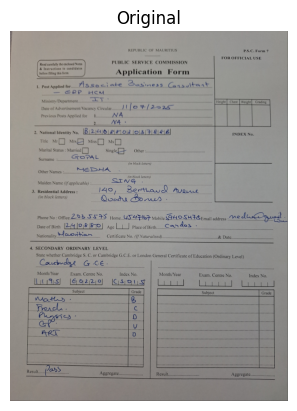

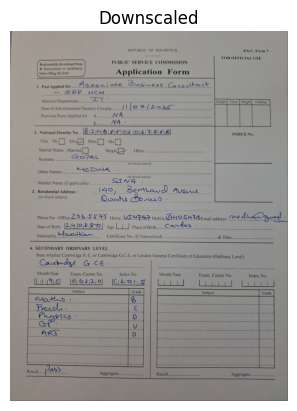

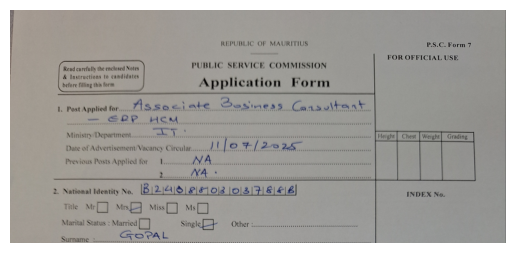

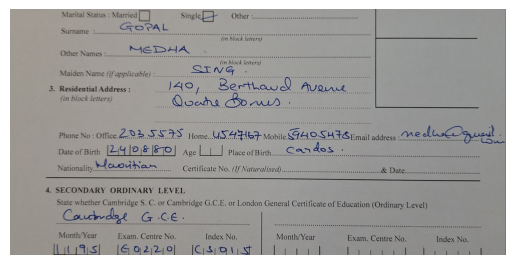

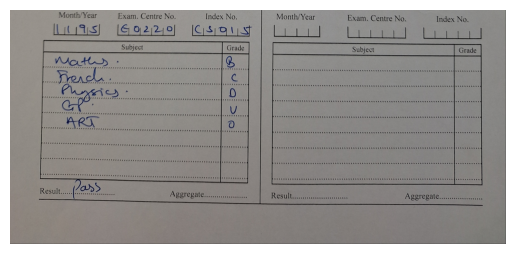

{
  "Post Applied for": "Associate Business Consultant",
  "Ministry/Department": "IT",
  "Date of Advertisement/Vacancy Circular": "11/07/2025",
  "Previous Posts Applied for": [
    "NA",
    "NA"
  ],
  "National Identity No": "82408503037856",
  "Title": "Mrs",
  "Marital Status": "Single",
  "Surname": "GOPAL"
}
{
  "Marital Status": "Single",
  "Surname": "GOPAL",
  "Other Names": "MEDHA",
  "Maiden Name": "SING",
  "Residential Address": "140, Berthawd Avenue, Quate Bones.",
  "Phone No. Office": "203 5575",
  "Phone No. Home": "4547167",
  "Phone No. Mobile": "940 5476",
  "Email address": "medha@gamil.com",
  "Date of Birth": "24 08 870",
  "Age": "",
  "Place of Birth": "Candos",
  "Nationality": "Hawaiitian",
  "Certificate No. (If Naturalised)": "",
  "Secondary Ordinary Level": "Cambridge G.C.E.",
  "Month/Year": "11 1985",
  "Exam. Centre No.": "G0220",
  "Index No.": "C1915"
}
{
  "Month/Year": "11/95",
  "Exam. Centre No.": "60220",
  "Index No.": "CS015",
  "Subject": 

In [8]:
# OCR_config(image_path, max_size, no_of_slices, pixels_overlap, prompt)

config_1 = OCR_config(
    '/kaggle/input/psc-forms/20251117_094257.jpg',
    1280,
    3,
    50,
    'Retrieve hand-filled application details in key value pair. Return in JSON'
)

run_ocr_pipeline(config_1)



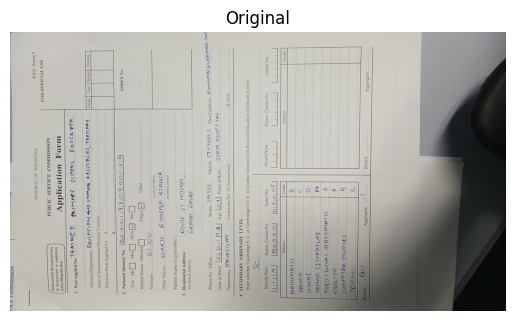

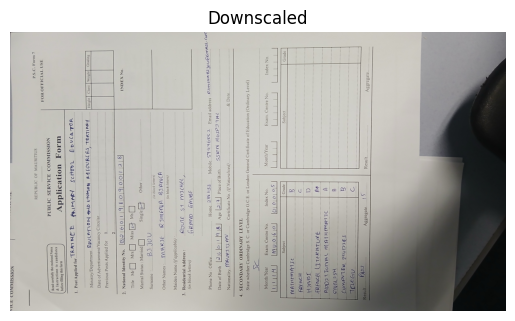

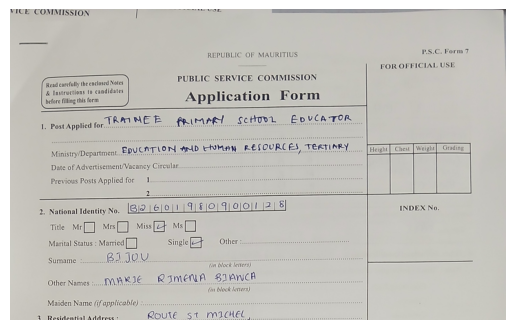

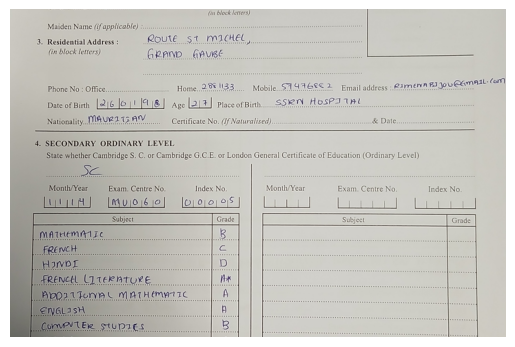

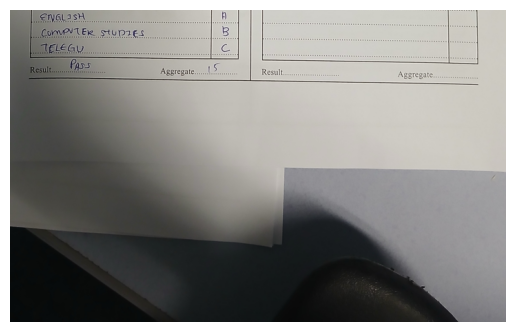

{
  "Post Applied For": "TRAIINEE PRIMARY SCHOOL EDUCATOR",
  "Ministry/Department": "EDUCATION AND HUMAN RESOURCES, TERTIARY",
  "National Identity No": "3216011980900128",
  "Title": "Ms",
  "Marital Status": "Single",
  "Surname": "BIJOV",
  "Other Names": "MARIE RIMENA BLANCA",
  "Maiden Name": "ROUTE ST MICHEL"
}
{
  "Maiden Name": "",
  "Residential Address": "ROUTE ST MICHEL, GRAND GAUBE",
  "Phone No. (Office)": "",
  "Phone No. (Home)": "2861133",
  "Phone No. (Mobile)": "57476852",
  "Email Address": "rimenar830@gmail.com",
  "Date of Birth": "26/01/1998",
  "Age": "21",
  "Place of Birth": "SSKN HOSPITAL",
  "Nationality": "MAURITIAN",
  "Certificate Type": "SC",
  "Month/Year (Exam 1)": "11/14",
  "Exam Centre No. (Exam 1)": "MU060",
  "Index No. (Exam 1)": "0006095",
  "Subjects and Grades": [
    {
      "Subject": "MATHEMATICS",
      "Grade": "B"
    },
    {
      "Subject": "FRENCH",
      "Grade": "C"
    },
    {
      "Subject": "HINDI",
      "Grade": "D"
    },
 

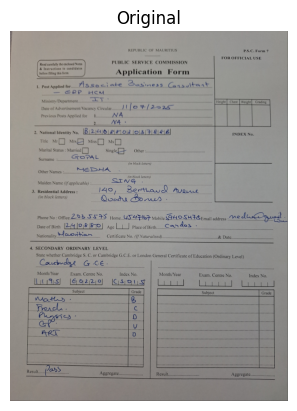

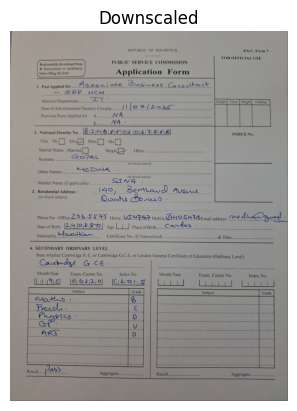

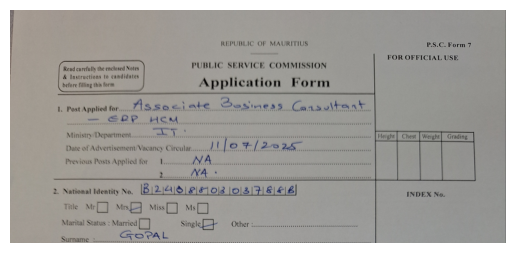

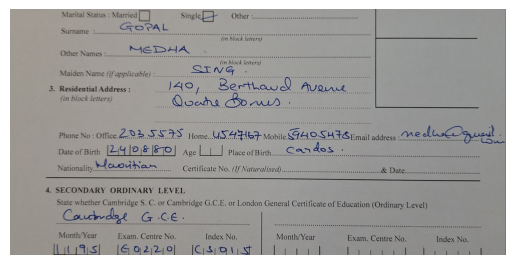

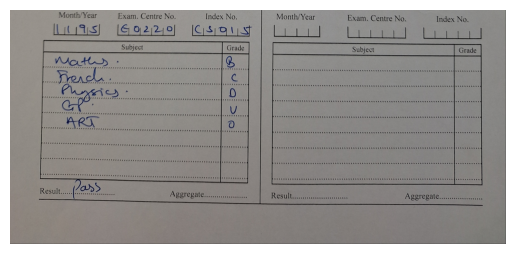

{
  "Post Applied for": "Associate Business Consultant",
  "Ministry/Department": "IT",
  "Date of Advertisement/Vacancy Circular": "11/07/2025",
  "Previous Posts Applied for": [
    "NA",
    "NA"
  ],
  "National Identity No": "82408503037856",
  "Title": "Mrs",
  "Marital Status": "Single",
  "Surname": "GOPAL"
}
{
  "Marital Status": "Single",
  "Surname": "GOPAL",
  "Other Names": "MEDHA",
  "Maiden Name": "SING",
  "Residential Address": "140, Berthawd Avenue, Quatre Bornes",
  "Phone No. Office": "203 5575",
  "Phone No. Home": "4547167",
  "Phone No. Mobile": "940 5476",
  "Email Address": "medha@gmail.com",
  "Date of Birth": "24 08 870",
  "Age": "",
  "Place of Birth": "Carcos",
  "Nationality": "Havaitian",
  "Certificate No. (If Naturalised)": "",
  "Secondary Ordinary Level": "Cambridge G.C.E.",
  "Month/Year": "11 1985",
  "Exam. Centre No.": "60220",
  "Index No.": "C1915"
}
{
  "Month/Year": "11/95",
  "Exam. Centre No.": "60220",
  "Index No.": "CS015",
  "Subject": 

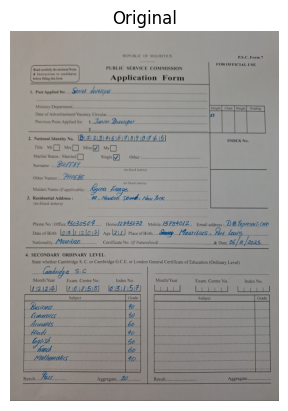

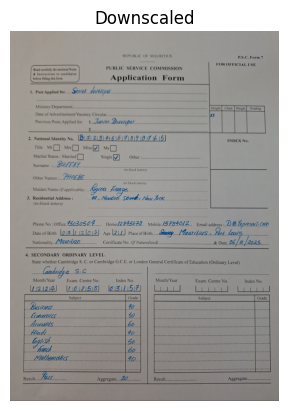

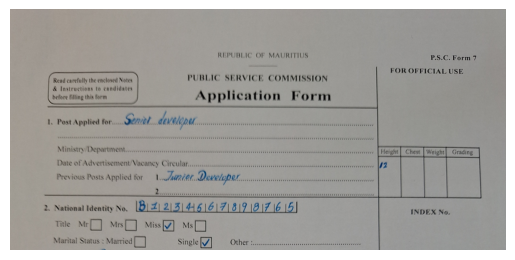

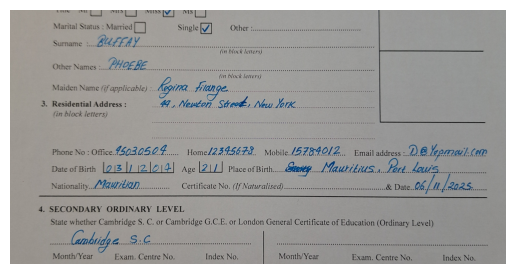

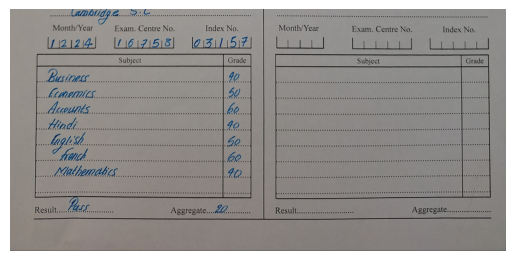

{
  "Post Applied for": "Senior developer",
  "Ministry/Department": "",
  "Date of Advertisement/Vacancy Circular": "",
  "Previous Posts Applied for": "Junior Developer",
  "National Identity No.": "8123467898765",
  "Title": "Miss",
  "Marital Status": "Single"
}
{
  "Title": "Miss",
  "Marital Status": "Single",
  "Surname": "BUFFAY",
  "Other Names": "PHOEBE",
  "Maiden Name": "Regina Frange",
  "Residential Address": "44, Newton Street, New York",
  "Phone No: Office": "45030509",
  "Phone No: Home": "12345678",
  "Phone No: Mobile": "15784012",
  "Email address": "D@Yopmail.com",
  "Date of Birth": "03/12/04",
  "Age": "21",
  "Place of Birth": "Sunny Mauritius, Port Louis",
  "Nationality": "Mauritian",
  "Certificate No. (If Naturalised)": "",
  "Date of Naturalisation": "06/11/2025",
  "Secondary Ordinary Level": "Cambridge S.C."
}
{
  "Month/Year": "12 24",
  "Exam. Centre No.": "16758",
  "Index No.": "03157",
  "Subject": "Business",
  "Grade": "40",
  "Subject": "Economic

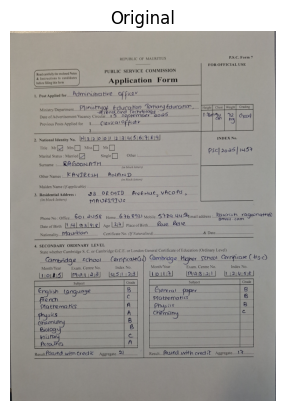

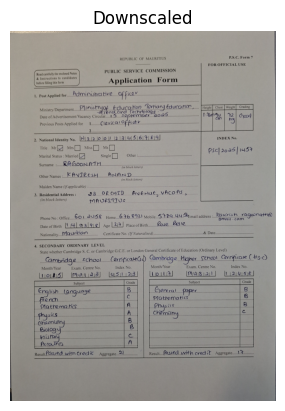

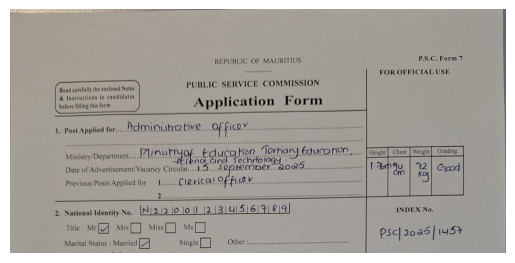

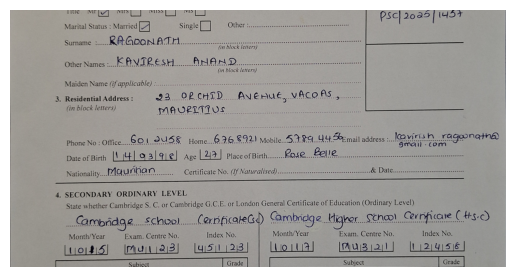

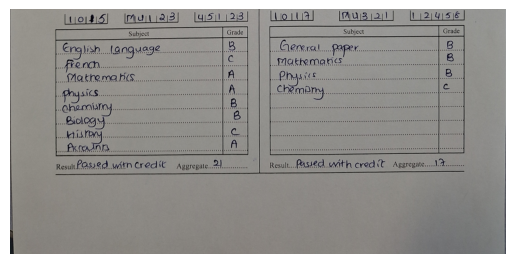

{
  "Post Applied For": "Administrative officer",
  "Ministry/Department": "Ministry of Education, Tertiary Education, Science and Technology",
  "Date of Advertisement/Vacancy Circular": "15 September 2025",
  "Previous Posts Applied For": [
    "Clerical officer"
  ],
  "National Identity No": "N2200123456789",
  "Title": "Mr",
  "Marital Status": "Married",
  "Height": "1.76m",
  "Chest": "90 cm",
  "Weight": "72 Kg",
  "Grading": "Good",
  "Index No": "PSC|2025|1457"
}
{
  "Title": "Mr",
  "Marital Status": "Married",
  "Surname": "RAGOONATH",
  "Other Names": "KAVIRESH ANAND",
  "Maiden Name": "",
  "Residential Address": "23 ORCHID AVENUE, VACOAS, MAURITIUS",
  "Phone No. Office": "601 2458",
  "Phone No. Home": "676 8921",
  "Phone No. Mobile": "5781 4435",
  "Email Address": "kavirish.ragoonatha@gmail.com",
  "Date of Birth": "14 03 1998",
  "Age": "29",
  "Place of Birth": "Rose Belle",
  "Nationality": "Mauritian",
  "Certificate No. (If Naturalised)": "",
  "Secondary Ordina

In [6]:
# Testing with multiple configurations
# OCR_config(image_path, max_size, no_of_slices, pixels_overlap, prompt)

configs = [
    OCR_config(
        '/kaggle/input/psc-forms/20250407_150848.jpg',
        1280,
        3,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),
    
    OCR_config(
        '/kaggle/input/psc-forms/20251117_094257.jpg',
        1280,
        3,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),

    OCR_config(
        '/kaggle/input/psc-forms/20251117_094152.jpg',
        1280,
        3,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),
    
    OCR_config(
        '/kaggle/input/psc-forms/20251112_100725.jpg',
        1280,
        3,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),
]

for config in configs:
    run_ocr_pipeline(config)

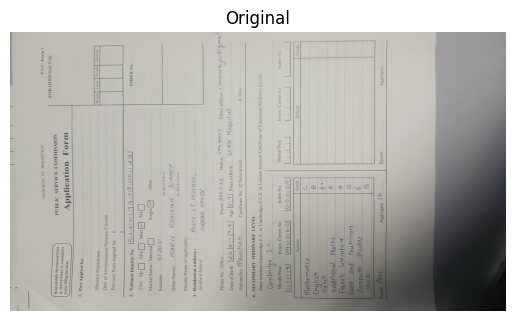

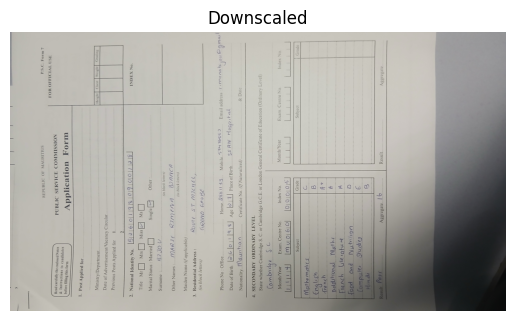

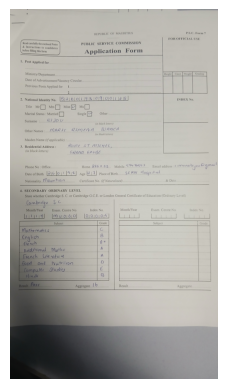

{
  "Post Applied For": "",
  "Ministry/Department": "",
  "Date of Advertisement/Vacancy Circular": "",
  "Previous Posts Applied For": "",
  "National Identity No.": "82601980900128",
  "Title": "Ms",
  "Marital Status": "Single",
  "Surname": "Bijou",
  "Other Names": "MARIE RIMENA BIANCHA",
  "Maiden Name": "ROUTE ST MICHEL, GRAND GRUBE",
  "Phone No. Office": "",
  "Phone No. Home": "8881133",
  "Phone No. Mobile": "5743666",
  "Email Address": "rimenabou@gmail",
  "Date of Birth": "26/01/1980",
  "Age": "37",
  "Place of Birth": "35 RN Hospital",
  "Nationality": "Maunthan",
  "Certificate No.": "",
  "Secondary Ordinary Level": {
    "Exam Type": "Cambridge S.C.",
    "Month/Year": "11/11/14",
    "Exam Centre No.": "MUD0160",
    "Index No.": "0101015",
    "Subjects": [
      {
        "Subject": "Mathematics",
        "Grade": "C"
      },
      {
        "Subject": "English",
        "Grade": "B"
      },
      {
        "Subject": "French",
        "Grade": "A+"
      },
  

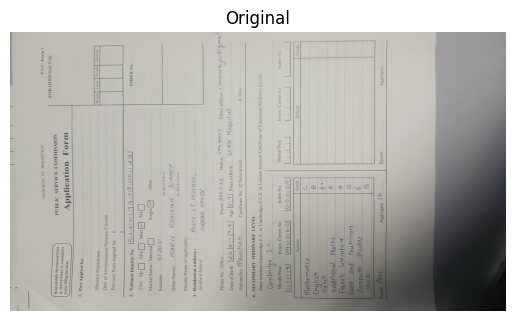

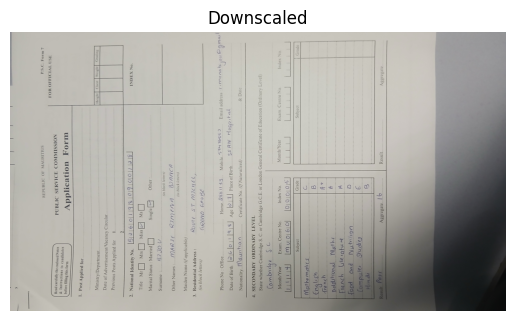

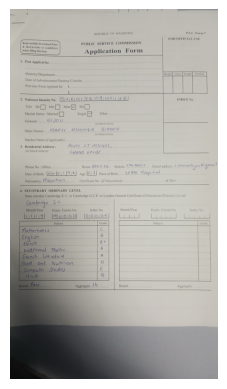

{
  "Post Applied for": "",
  "Ministry/Department": "",
  "Date of Advertisement/Vacancy Circular": "",
  "Previous Posts Applied for": {
    "1": "",
    "2": ""
  },
  "National Identity No.": "812601980910125",
  "Title": "Miss",
  "Marital Status": "Single",
  "Surname": "BJJOV",
  "Other Names": "MARIC RIMENA BJANCA",
  "Maiden Name (if applicable)": "",
  "Residential Address": "ROUTE ST MICHEL, GRAND GAUBE",
  "Phone No. Office": "",
  "Phone No. Home": "8851133",
  "Phone No. Mobile": "57476992",
  "Email address": "rimenabjou@gmail.com",
  "Date of Birth": "26/01/1989",
  "Age": "27",
  "Place of Birth": "35 RN Hospital",
  "Nationality": "Mauritian",
  "Certificate No. (if Naturalised)": "",
  "Secondary Ordinary Level": {
    "Exam Type": "Cambridge S.C.",
    "Month/Year": "11/11/14",
    "Exam Centre No.": "MU01610",
    "Index No.": "01010105",
    "Subjects and Grades": [
      {
        "Subject": "Mathematics",
        "Grade": "C"
      },
      {
        "Subject": 

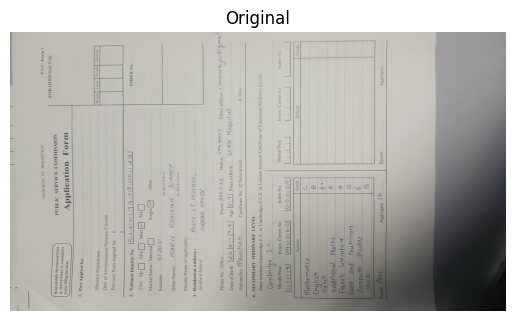

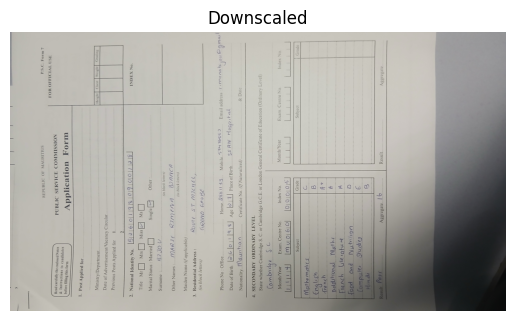

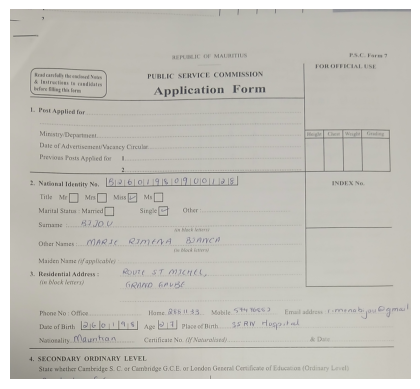

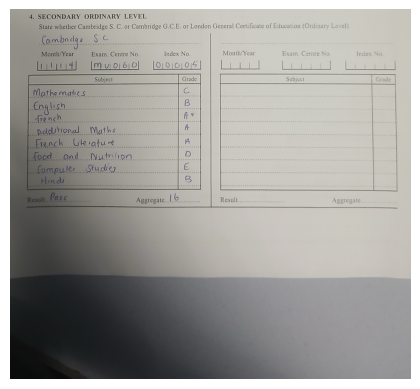

{
  "Post Applied for": "",
  "Ministry/Department": "",
  "Date of Advertisement/Vacancy Circular": "",
  "Previous Posts Applied for": [
    "",
    ""
  ],
  "National Identity No": "8260198090012",
  "Title": "Miss",
  "Marital Status": "Single",
  "Surname": "BJ JOU",
  "Other Names": "MARIE RIMENA BIANCA",
  "Maiden Name": "",
  "Residential Address": "ROUTE ST MICHEL, GRAND GAUCHE",
  "Phone No (Office)": "",
  "Phone No (Home)": "2881133",
  "Mobile": "5747666",
  "Email Address": "r.menaby@gmail.com",
  "Date of Birth": "26/01/198",
  "Age": "37",
  "Place of Birth": "SSRN Hospital",
  "Nationality": "Mauritian",
  "Certificate No": "",
  "Secondary Ordinary Level": ""
}
{
  "exam_type": "Cambridge S.C.",
  "month_year": "11/11/14",
  "exam_centre_no": "MU0160",
  "index_no": "010106",
  "subjects": [
    {
      "subject": "Mathematics",
      "grade": "C"
    },
    {
      "subject": "English",
      "grade": "B"
    },
    {
      "subject": "French",
      "grade": "A*"
 

In [10]:
# Testing same image with multiple configurations
# OCR_config(image_path, max_size, no_of_slices, pixels_overlap, prompt)

configs = [
    OCR_config(
        '/kaggle/input/psc-forms/20250407_135902.jpg',
        1024,
        1,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),
    
    OCR_config(
        '/kaggle/input/psc-forms/20250407_135902.jpg',
        1280,
        1,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),

    OCR_config(
        '/kaggle/input/psc-forms/20250407_135902.jpg',
        1280,
        2,
        50,
        'Retrieve hand-filled application details in key value pair. Return in JSON'
    ),
]

for config in configs:
    run_ocr_pipeline(config)

In [ ]:
import torch
torch.cuda.empty_cache() 